# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
# These libraries may be useful to you

from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

#import gensim
#import gensim.corpora as corpora
#from gensim.utils import simple_preprocess
#from gensim.models import CoherenceModel,LdaMulticore, Phrases 
#from gensim.models.phrases import Phraser 
#from gensim.corpora import Dictionary

import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')



In [2]:
# add any additional libaries you need here
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

from yellowbrick.text import FreqDistVisualizer
from yellowbrick.datasets import load_hobbies

from sklearn.decomposition import LatentDirichletAllocation




In [3]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [4]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [5]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [6]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


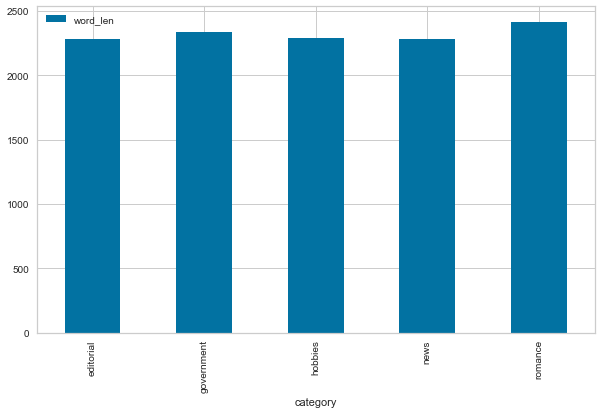

In [7]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [8]:
count_text_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

C:\Users\elfek\AppData\Roaming\Python\Python38\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [9]:
count_text_vectorizer.get_feature_names_out()

array(['00', '000', '10', ..., 'youth', 'zone', 'zoning'], dtype=object)

In [32]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape


C:\Users\elfek\AppData\Roaming\Python\Python38\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [33]:
tfidf_text_vectorizer.get_feature_names_out()

array(['00', '000', '10', ..., 'youth', 'zone', 'zoning'], dtype=object)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: 
count_text_vectors: contains a sparse representation matrix of the token counts.
tfidf_text_vectors: contains a matrix of TF-IDF features, which means to get a matrix representation of token counts and then normalize it and then perform a term frequency. 

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [34]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

C:\Users\elfek\AppData\Roaming\Python\Python38\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [35]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.40)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.64)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.01)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


C:\Users\elfek\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [36]:
#df.loc[ df['category'] == categories[0], 'text']


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

C:\Users\elfek\AppData\Roaming\Python\Python38\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(
C:\Users\elfek\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\elfek\AppData\Roaming\Python\Python38\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(
C:\Users\elfek\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_featur

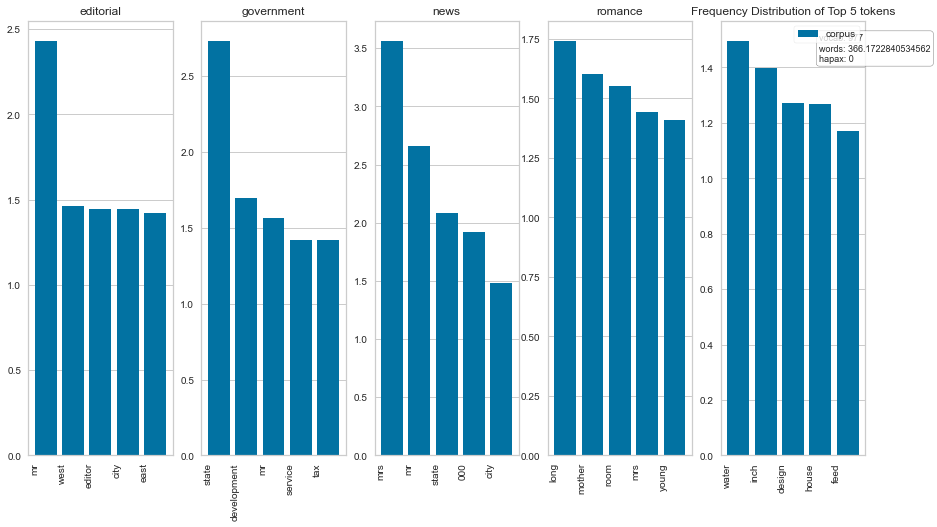

In [37]:
# Your code here
categories
fig, axs = plt.subplots(1, 5,figsize=(15,8))

# Load the text data
for i in range (0,5):
    corpus = df.loc[ df['category'] == categories[i], 'text']
    #print("Top words for category:" + categories[i])
    axs[i].set_title(categories[i])
    #axs[i].legend().set_visible(False)
    #axs[i].get_legend().set_visible(False)
    #axs[i].legend().legendPatch.set_visible(False)
    tfidf_text_vectorizer2 =  TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
    docs = tfidf_text_vectorizer2.fit_transform(corpus) #CountVectorizer()
    features   = tfidf_text_vectorizer2.get_feature_names()

    visualizer = FreqDistVisualizer(ax = axs[i],features=features, orient='v', n = 5)
    visualizer.fit(docs)
visualizer.show()

Q: How does your five-topic NMF model compare to the original Brown categories? 

A: The performance of the five-topic NFM model isn't very good. There is a lot of overlap between the topics in words used. So the topics are not differentiated much compared to the original brown categories with the exception of 2-3 topics.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

In [39]:
# Your code here
svd_para_model = TruncatedSVD( n_components = 5, random_state = 42)
W_svd_para_matrix = svd_para_model.fit_transform( tfidf_text_vectors)
H_svd_para_matrix = svd_para_model.components_


In [40]:
display_topics(svd_para_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.14)
  mr (1.73)
  said (1.05)
  kennedy (0.81)
  president (0.77)

Topic 03
  mrs (30.38)
  club (6.70)
  game (6.40)
  jr (5.81)
  dallas (5.50)

Topic 04
  game (4.33)
  league (3.09)
  baseball (3.06)
  ball (2.94)
  team (2.81)


C:\Users\elfek\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Q: How does your five-topic LSA model compare to the original Brown categories? 

A: The LSA model seems to perform similarly poorly as the NNMF model compared to the brown categories. Maybe only 2-3 of the topic match. The same problem of lack of differentiation between the topics 0,2, and 3. Topic 0 is an especially weak topic.

Q: What is your interpretation of the display topics output? 

A: It seems to me that editorial and news categorize are very generic. It is difficult to have a central theme when there a lot of variation in the each document in the corpus.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [22]:
# Fit your LDA model here

count_para_vectorizer = CountVectorizer( stop_words = stopwords, min_df = 5, max_df = 0.7)
count_para_vectors = count_para_vectorizer.fit_transform( df["text"])
lda_text_model = LatentDirichletAllocation( n_components = 5, random_state = 42)
W_lda_matrix = lda_text_model.fit_transform( count_para_vectors)
H_lda_matrix = lda_text_model.components_


C:\Users\elfek\AppData\Roaming\Python\Python38\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


In [23]:
# Call `display_topics` on your fitted model here
display_topics(lda_text_model, count_para_vectorizer.get_feature_names())


Topic 00
  home (0.46)
  right (0.35)
  game (0.35)
  way (0.34)
  set (0.34)

Topic 01
  state (0.89)
  development (0.57)
  states (0.51)
  program (0.46)
  use (0.44)

Topic 02
  said (0.93)
  mr (0.73)
  president (0.63)
  state (0.49)
  mrs (0.48)

Topic 03
  feed (0.90)
  general (0.73)
  business (0.70)
  property (0.69)
  shall (0.67)

Topic 04
  said (1.56)
  man (0.62)
  little (0.62)
  old (0.59)
  good (0.53)


C:\Users\elfek\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [24]:
categories

['editorial', 'government', 'news', 'romance', 'hobbies']

Q: What inference do you draw from the displayed topics for your LDA model? 

A: The probablistic ranking of the top five words still has low weights for most words so the groups are not well defined.


Q: How does your five-topic LDA model compare to the original Brown categories? 

A: I am more satisfied with the five-topic LDA model. Topics 1 and 2 are similar i.e. the government should be in the news. The other top words make sense as well.

In [25]:
lda_display = pyLDAvis.sklearn.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

c:\Users\elfek\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [26]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: The principle component scatterplot demonstates that news is similar to (overlaps) with both government and romance corpora. Although the salient terms graph shows it still has enough terms unique to it. Interestingly enough the romance corpus can be almost completely included inside the news. Romance, editorial, and hobbies have the smallest marginal topic distribution meaning that the top words take up a small percentage of the total words. Furthermore, the top words in the news category have relatively close frequencies. I would say that 3 groups would be more clearly defined than 5.
